<center><h1>Volume Prediction</h1>

#### <center>Supervisor: Merrell Hora</center> <center>Students: Guoli Rao, Kalo Qian</center>

# Part one: Data preperation

In [1]:
# Import all necessary packages
import os
import sys
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import expon
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from datetime import time
from datetime import datetime
from time import strftime
from time import gmtime
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
from sklearn.preprocessing import OneHotEncoder
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import kpss
import time as tm

import tensorflow as tf
from keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from keras.layers import Embedding, Flatten, Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Input, Concatenate
from keras.models import Model
import itertools

import warnings
warnings.filterwarnings("ignore")


import TAQReaders
from TAQReaders import TAQTradesReader
from TAQReaders import TAQQuotesReader

In [2]:
def generateDataset(df, timeStep=130, trainRatio=0.95, validation=True, validationRatio=0.05):
    '''
    Return a list of training and testing dataset and validation dataset if validation is True

        Parameters:
                df: dataframe that contains the data
                timeStep: number of time steps for each sample
                trainRatio: ratio of training data
                validation: boolean, whether to split training data into training and validation set
                validationRatio: ratio of validation data
        Returns:
                X_train: training data
                Y_train: training label
                X_test: testing data
                Y_test: testing label
                X_val: validation data
                Y_val: validation label
    '''
    dataX = []
    dataY = []
    for i in range(timeStep, len(df)):
        dataX.append(df.values[i-timeStep:i])
        dataY.append(df.values[i, 0]) #Setting the target feature to be volumn

    def trainValidationTestSplit(dataset, trainRatio=trainRatio, validation=validation, validationRatio=validationRatio):
        def testTrainSplit(df, trainRatio=trainRatio):
            cut_pt = int(trainRatio*len(df))
            train, test = df[0:cut_pt], df[cut_pt:]
            return train, test
        if validation:
            train, test = testTrainSplit(dataset, trainRatio=trainRatio)
            train, validation = testTrainSplit(train, trainRatio=1-validationRatio)
            return train, validation, test
        else:
            train, test = testTrainSplit(dataset, trainRatio=trainRatio)
            return train, test
        
    X, Y = np.array(dataX), np.array(dataY)
    if validation:
        X_train, X_validation, X_test = trainValidationTestSplit(X)
        Y_train, Y_validation, Y_test = trainValidationTestSplit(Y)
        return X_train, X_validation, X_test, Y_train, Y_validation, Y_test
    else:
        X_train, X_test = trainValidationTestSplit(X)
        Y_train, Y_test = trainValidationTestSplit(Y)
        return X_train, X_test, Y_train, Y_test

def getData(dates, dataPath, symbol = 'SPY', displayLog = False, extendHours = False):
    '''
    Return a dataframe that contains the data for the given dates
    
            Parameters:
                    dates: list of dates in string format
                    dataPath: path to the data
                    symbol: ticker symbol
                    displayLog: boolean, whether to display the log
                    extendHours: boolean, whether to include extended hours data
            Returns:
                    df: dataframe that contains the data
    '''
    def readData(path):
        with open(path) as f:
            contents = f.readlines()
        columns = contents[0]
        columnsName = []
        blankIndex = columns.find(' ')
        while(blankIndex>=0):
            columnsName.append(columns[:blankIndex])
            columns = columns[blankIndex+1:]
            blankIndex = columns.find(' ')
        columnsName.append(columns[:blankIndex])
        data = []
        for i in range(1,len(contents)):
            temp = []
            current = contents[i]
            blankIndex = current.find(' ')
            while(blankIndex>=0):
                temp.append(current[:blankIndex])
                current = current[blankIndex+1:]
                blankIndex = current.find(' ')
            temp.append(current[:blankIndex])
            data.append(temp)
        df = pd.DataFrame(data = data, columns = columnsName)
        return df

    nDates = len(dates)
    outputDF = []
    for d in range(nDates):

        if displayLog:
            print('Reading file: ', dataPath+symbol+dates[d])
        path = (dataPath + '/' + '/bars.' + symbol + '.' + dates[d])
        df = readData(path)
        df['date'] = dates[d]
        if extendHours:
            outputDF.append(df)
        else:
            outputDF.append(df[(df.time <= '16:00:00') & (df.time > '09:30:00')])
        if displayLog:
            print('Reading file: ', dataPath+symbol+dates[d], ' done!')
    outputDF = pd.concat(outputDF)
    columns = ['date','time','trade_count','trade_volume','trade_first','trade_high','trade_low','trade_last','vwap']
    outputDF = outputDF.loc[:, columns]
    outputDF = outputDF.set_index(['date','time'])
    columnRenames = {'trade_count':'count','trade_volume':'volume','trade_first':'open','trade_high':'high','trade_low':'low','trade_last':'close','vwap':'vwap'}
    outputDF = outputDF.rename(columns = columnRenames)
    # Change the data type of the columns to float
    outputDF = outputDF.astype(float)
    outputDF['logVolume'] = outputDF[['volume']].applymap(lambda x : np.log(x))
    outputDF['hlDiff'] = outputDF[['high','low']].apply(lambda x : x[0]-x[1], axis = 1)
    return outputDF

def getDates(path):
    '''
    Return a list of dates in string format
        
            Parameters:
                    path: path to the data
            Returns:
                    dates: list of dates in string format
    '''

    dates = []
    for file in os.listdir(path):
        if file.startswith("bars"):
            dates.append(file[-8:])
    dates = sorted(dates)
    return dates

def predictionReport(Y_test, Y_predicted, model = 'LSTM'):
    '''
    Return the prediction report
            
            Parameters:
                    Y_test: testing label
                    Y_predicted: predicted label
                    model: model name
            Returns:
                    None
    ''' 
    if(model == 'LSTM'):
        print('Result from LSTM model with volumn and close price features:')
    else:
        print('Results from '+model+' model')
    MAE = mean_absolute_error(Y_test, Y_predicted)
    print("MAE: "+str(MAE))
    RMAE = np.sqrt(MAE)
    print("RMAE: "+str(RMAE))
    MSE = mean_squared_error(Y_test, Y_predicted)
    print("MSE: "+str(MSE))
    RMSE = np.sqrt(MSE)
    print("RMSE: "+str(RMSE))
    CD = 0
    sign1 = np.sign(np.diff(Y_predicted, axis=0))
    sign2 = np.sign(np.diff(Y_test, axis=0))
    for i in range(len(sign1)):
        if(sign1[i]==sign2[i]):
            CD +=1
    CD = CD/len(sign1)
    print("CD: "+str(CD))


def getRecords(dfs):
    '''
    Return the records from dfs that time is not 16:00:00
            
            Parameters:
                    dfs: the dataframe of the data
            Returns:
                    dfs: the dataframe of the data
    '''
    df = dfs[dfs.index.get_level_values('time') != '16:00:00']
    return df

def kpss_test(series, **kw):
    '''
    KPSS test for stationarity
    Null hypothesis: the process is trend stationary
    Alternative hypothesis: the process is not trend stationary
    '''
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')


In [3]:
dataPath = '/Users/guolir/Desktop/Volumn Project/Data/SPY_Data_Decompressed/SPY'
dates = getDates(dataPath)
dfs = getData(dates, dataPath, displayLog = False)
dfs.head()

count    volume    open     high     low   close  \
date     time                                                          
20220103 09:31:00  3379.0  398188.0  476.75  476.585  476.22  476.47   
         09:32:00  2757.0  202306.0  476.75  476.820  476.31  476.70   
         09:33:00  2519.0  236129.0  476.75  476.780  476.45  476.54   
         09:34:00  1617.0  142559.0  476.75  477.000  476.55  476.99   
         09:35:00  2314.0  204234.0  476.75  477.160  476.93  477.07   

                       vwap  logVolume  hlDiff  
date     time                                   
20220103 09:31:00  476.4477  12.894680   0.365  
         09:32:00  476.6033  12.217537   0.510  
         09:33:00  476.5848  12.372134   0.330  
         09:34:00  476.7846  11.867511   0.450  
         09:35:00  477.0469  12.227022   0.230

In [4]:
dfs.describe() # Get the summary statistics of the data

,count,volume,open,high,low,close,vwap,logVolume,hlDiff
count,22620.000000,2.262000e+04,22620.000000,22620.000000,22620.000000,22620.000000,22620.000000,22620.000000,22620.000000
mean,2036.735588,1.458527e+05,446.621552,446.530045,446.175297,446.353398,446.351905,11.572792,0.354747
std,2058.951507,1.702718e+05,15.076350,14.954673,15.026164,14.990548,14.990903,0.756603,0.218147
min,115.000000,7.456000e+03,419.220000,415.830000,415.120000,415.460000,415.509400,8.916774,0.040000
25%,851.000000,6.200200e+04,433.680000,435.080000,434.600000,434.830000,434.847625,11.034922,0.210000
50%,1423.000000,1.029660e+05,445.240000,446.925000,446.580000,446.740000,446.738100,11.542154,0.300000
75%,2475.000000,1.735360e+05,458.700000,456.960000,456.710000,456.830000,456.827675,12.064140,0.440000
max,41735.000000,6.040740e+06,479.350000,479.980000,479.690000,479.870000,479.825000,15.614037,2.430000


In [5]:
dfs.isna().sum().sum() # Check if there is any missing value

0

# Part two: Approach with time series models and some benchmark models and MEM, LSTM

## 1. Naive Forecast
* Using previous timestamp's volume as prediction for volume of current timestamp

In [6]:
length_y_test = 1125 # The length of the testing set, which is a length that consistent with the length of the prediction from the LSTM model
train_naive, test_naive = np.array(dfs.iloc[:-length_y_test]), np.array(dfs.iloc[-length_y_test:])

Results from Naive model
MAE: 38080.24711111111
RMAE: 195.14160784187237
MSE: 21154769393.104
RMSE: 145446.7923094353
CD: 0.3692170818505338


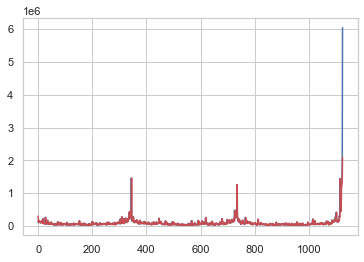

In [7]:
naive = np.array(dfs.iloc[-length_y_test-1:-1])
predictionReport(test_naive[:,1],naive[:,1],'Naive')
plt.plot(test_naive[:,1], color = 'b')
plt.plot(naive[:,1], color = 'r')

## 2. ARIMA

* According to the acf plot, the significance line is too lower, but we choose d=1 and q=2 for ARIMA(p,d,q) since it produce relatively lower AIC score.
* Use pacf plot to pick p=2 with the same reason.

In [8]:
length_y_test = 1125 # The length of the testing set, which is a length that consistent with the length of the prediction from the LSTM model
dfs2 = dfs.copy()
dfs2['timeIndex'] = [i%390 for i in range(len(dfs))]
train_arima, test_arima = np.array(dfs2.iloc[:-length_y_test]), np.array(dfs2.iloc[-length_y_test:])
dfs2.head()

count    volume    open     high     low   close  \
date     time                                                          
20220103 09:31:00  3379.0  398188.0  476.75  476.585  476.22  476.47   
         09:32:00  2757.0  202306.0  476.75  476.820  476.31  476.70   
         09:33:00  2519.0  236129.0  476.75  476.780  476.45  476.54   
         09:34:00  1617.0  142559.0  476.75  477.000  476.55  476.99   
         09:35:00  2314.0  204234.0  476.75  477.160  476.93  477.07   

                       vwap  logVolume  hlDiff  timeIndex  
date     time                                              
20220103 09:31:00  476.4477  12.894680   0.365          0  
         09:32:00  476.6033  12.217537   0.510          1  
         09:33:00  476.5848  12.372134   0.330          2  
         09:34:00  476.7846  11.867511   0.450          3  
         09:35:00  477.0469  12.227022   0.230          4

In [9]:
# KPSS test
kpss_test(train_arima[:,1])

KPSS Statistic: 0.8112610587949656
p-value: 0.01
num lags: 84
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


In [10]:
def deseasonalize(train,nBins = 390):
    def buildSeasonalityFactor(train,nBins = 390):
        seasonalityFactor = np.zeros(nBins)
        counter = np.zeros(nBins)
        for x in train:
            index = int(x[-1])
            volume = x[1]
            counter[index] = counter[index]+1
            seasonalityFactor[index] = seasonalityFactor[index]+volume
        for i in range(nBins):
            if counter[i] > 0:
                seasonalityFactor[i] = seasonalityFactor[i]/counter[i]
        return seasonalityFactor
    
    seasonalityFactor = buildSeasonalityFactor(train,nBins)
    ds = np.zeros((len(train),2))
    for i in range(len(ds)):
        index = int(train[i][-1])
        volume = train[i][1]
        ds[i][0] = volume/seasonalityFactor[index]
        ds[i][1] = index
    return (ds,seasonalityFactor)

In [11]:
ds_train,s = deseasonalize(train_arima)

# KPSS test
kpss_test(ds_train[:,0])


KPSS Statistic: 1.3442168557178216
p-value: 0.01
num lags: 85
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


Text(0.5, 1.0, 'ACF for second order differenced data')

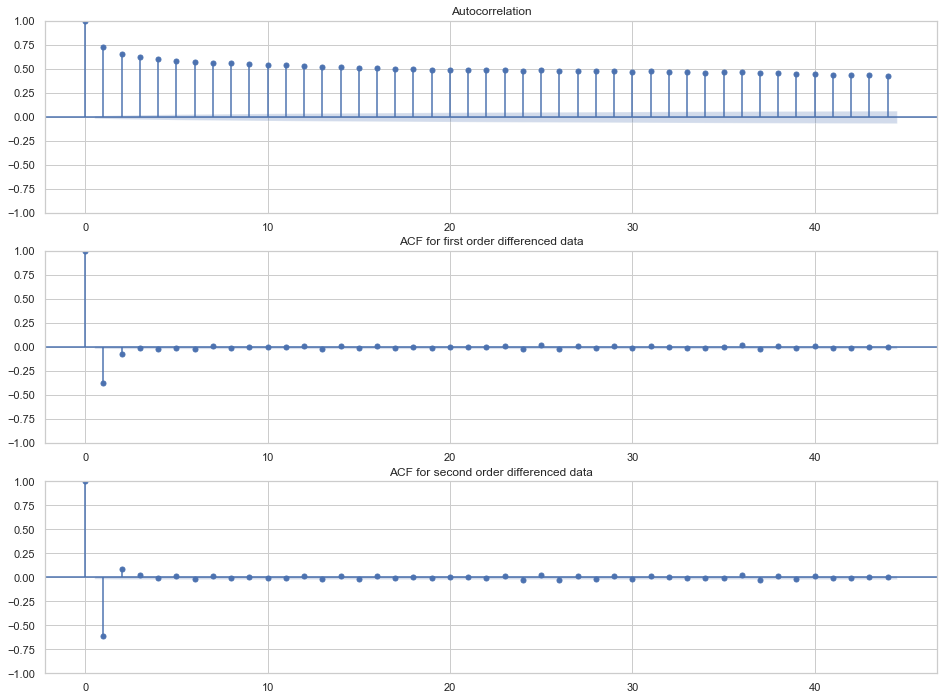

In [12]:
temp_ds = ds_train[:,0]
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(311)
plot_acf(temp_ds,ax = ax);

ax2 = fig.add_subplot(312)
plot_acf(np.diff(temp_ds),ax = ax2);
plt.title('ACF for first order differenced data')

ax3 = fig.add_subplot(313)
plot_acf(np.diff(np.diff(temp_ds)),ax = ax3);
plt.title('ACF for second order differenced data')

Text(0.5, 1.0, 'PACF for second order differenced data')

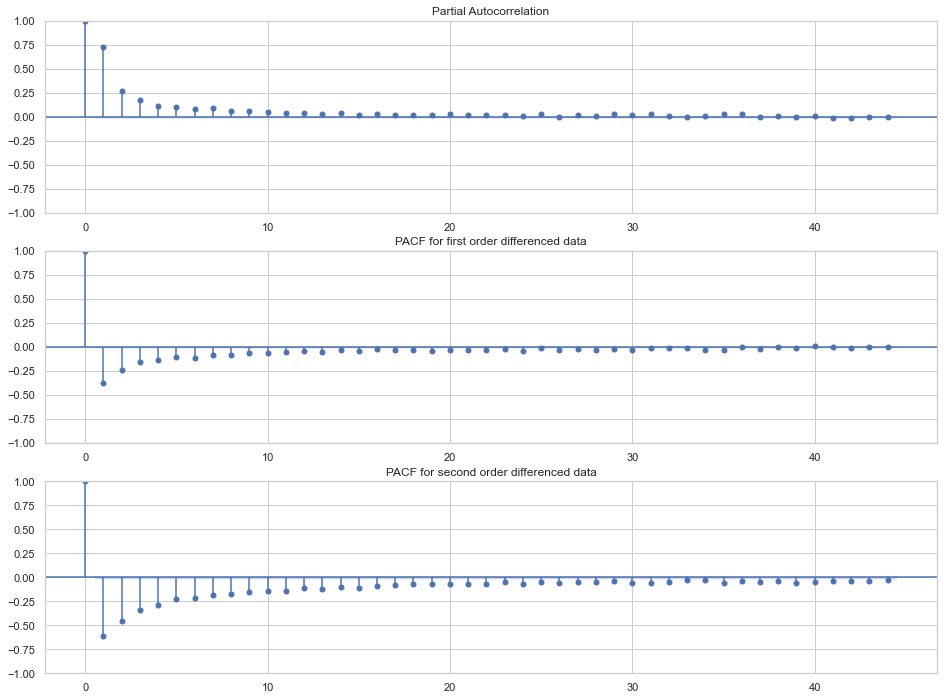

In [13]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(311)
plot_pacf(temp_ds, ax=ax);

ax2 = fig.add_subplot(312)
plot_pacf(np.diff(temp_ds), ax=ax2);
plt.title('PACF for first order differenced data')

ax3 = fig.add_subplot(313)
plot_pacf(np.diff(np.diff(temp_ds)),ax = ax3);
plt.title('PACF for second order differenced data')

In [14]:
model = ARIMA(temp_ds, order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                21495
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -13412.695
Date:                Thu, 01 Dec 2022   AIC                          26835.391
Time:                        13:42:00   BIC                          26875.268
Sample:                             0   HQIC                         26848.392
                              - 21495                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9047      0.032     28.567      0.000       0.843       0.967
ar.L2         -0.1155      0.013     -8.593      0.000      -0.142      -0.089
ma.L1         -1.4932      0.031    -48.047      0.0

Result from LSTM model with volumn and close price features:
MAE: 62385.821207126166
RMAE: 249.77153802450383
MSE: 23934431173.399143
RMSE: 154707.5666326607
CD: 0.5542704626334519


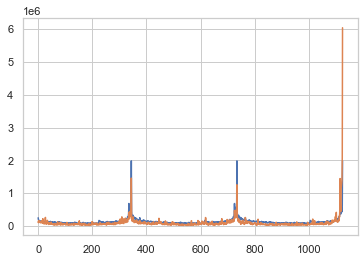

In [15]:
arima_est_ds = model_fit.forecast(1125)
arima_est = []
for i in range(len(arima_est_ds)):
    arima_est.append(s[int(test_arima[i][-1])]*arima_est_ds[i])
predictionReport(test_arima[:,1],arima_est)
plt.plot(arima_est)
plt.plot(test_arima[:,1])

prediction of next 1125 min and its  report. We can see that the CD of ARIMA(2,1,2) is larger than Naive Forecast but the error is much bigger.

## 3. MEM

In [16]:
def alphaCondPosterior(alphaPrev, beta, ds_train, alphaPriorMean, alphaPriorPrec, nBins = 390 ):
    totalObs = len(ds_train)
    vHat = ds_train.T[0]
    C = np.zeros([totalObs,2])
    h = np.zeros(totalObs)
    DInv = np.zeros([totalObs,totalObs])
    logPostPrev = 0 # log posterior evaluated at alphaPrev = log likelihood + log prior
    for t in range(1,totalObs):
        if ds_train[t][1] != 0:
            C[t,0] = 1 + beta*C[t-1,0]
            C[t,1] = vHat[t-1] + beta*C[t-1,1]
            h[t] = alphaPrev[0] + alphaPrev[1]*vHat[t-1] + beta*h[t-1]
        else:
            h[t] = alphaPrev[0]  # the first observation of the day has variance alpha_0
        DInv[t,t]=1/(2*h[t]*h[t])
        logPostPrev -= np.log(h[t]) + vHat[t]/h[t]

    CTDInv = np.dot(np.transpose(C),DInv)
    cPostPrecision = np.dot(CTDInv,C) + alphaPriorPrec
    cPostVariance = np.linalg.inv(cPostPrecision)
    cPostMean = np.dot(cPostVariance,(np.dot(CTDInv,vHat) + np.dot(alphaPriorPrec,alphaPriorMean)))
    # inefficient truncated sampling - replace
    alphaDraw = multivariate_normal.rvs(cPostMean,cPostVariance)
    maxTry = 25
    nTry = 0
    while np.min(alphaDraw) <= 0 and nTry < maxTry:
        alphaDraw = multivariate_normal.rvs(cPostMean,cPostVariance)
        nTry += 1
    if nTry >= maxTry:
        alphaDraw[0] = np.max(alphaDraw[0],0)
        alphaDraw[1] = np.max(alphaDraw[1],0)
        
    alphaDrawPDF = multivariate_normal.pdf(alphaDraw,cPostMean,cPostVariance)
    alphaPriorVar = np.linalg.inv(alphaPriorPrec) # move this out
    
    logPDFNew = np.log(alphaDrawPDF)
    
    logPostNew = 0
    for t in range(1,totalObs):
        if ds_train[t][1] != 0:
            h[t] = alphaDraw[0] + alphaDraw[1]*vHat[t-1] + beta*h[t-1]
        else:
            h[t] = alphaDraw[0]
        DInv[t,t]=1/(2*h[t]*h[t]) # Should we put 2 here? This appeares in the reference but not the original formula.
        logPostNew -= np.log(h[t]) + vHat[t]/h[t]
    CTDInv = np.dot(np.transpose(C),DInv)
    cPostPrecision = np.dot(CTDInv,C) + alphaPriorPrec
    cPostVariance = np.linalg.inv(cPostPrecision)
    cPostMean = np.dot(cPostVariance,(np.dot(CTDInv,vHat) + np.dot(alphaPriorPrec,alphaPriorMean)))
    alphaPrevPDF = multivariate_normal.pdf(alphaPrev,cPostMean,cPostVariance)

    logPostNew += multivariate_normal.logpdf( alphaDraw, alphaPriorMean, alphaPriorVar)
    
    logPostPrev += multivariate_normal.logpdf( alphaPrev, alphaPriorMean, alphaPriorVar)
    logPDFPrev = np.log(alphaPrevPDF)
    
    # acceptance/reject step
    aProb = np.exp(logPostNew-logPostPrev+logPDFPrev-logPDFNew)
    aProb = np.min([1,aProb])
    if np.random.uniform() > aProb:
        alphaDraw = alphaPrev
            
    return(alphaDraw,aProb)                

def betaCondPosterior(betaPrev, alpha, ds_train, priorMean, priorPrecision, nBins = 390):
    totalObs = len(ds_train)
    vHat = ds_train.T[0]
    G = np.zeros(totalObs)
    z = np.zeros(totalObs)
    h = np.zeros(totalObs)
    DInv = np.zeros([totalObs,totalObs])
    r = np.zeros(totalObs)
    cPostPrecision = priorPrecision
    cPostMean = priorPrecision*priorMean 
    logPostPrev = 0 # log posterior evaluated at betaPrev = log likelihood + log prior
    for t in range(1,totalObs):
        if ds_train[t][1] != 0:
            z[t] = vHat[t] - alpha[0] - (alpha[1] + betaPrev)*vHat[t-1] + betaPrev*z[t-1]
            G[t] = vHat[t-1] - z[t-1] + betaPrev*G[t-1]
            h[t] = alpha[0] + alpha[1]*vHat[t-1] + betaPrev*h[t-1]
            r[t] = z[t] + betaPrev*G[t]
        else:
            h[t] = alpha[0]
            r[t] = vHat[t] - alpha[0]
        DInv[t,t]=1/(h[t]*h[t])
        cPostPrecision += G[t]*DInv[t,t]*G[t]
        cPostMean += G[t]*DInv[t,t]*r[t]
        logPostPrev -= np.log(h[t]) + vHat[t]/h[t]

    cPostMean = (1/cPostPrecision)*(cPostMean)
    logPostPrev += norm.logpdf((betaPrev - priorMean)*np.sqrt(priorPrecision))

    betaDraw = (norm.rvs()/np.sqrt(cPostPrecision)) + cPostMean
    maxTry = 25
    nTry = 0
    while betaDraw <= 0 and nTry < maxTry:
        betaDraw = (norm.rvs()/np.sqrt(cPostPrecision)) + cPostMean
        nTry += 1
    if nTry >= maxTry:
        betaDraw = np.max(betaDraw,0)
    
    betaDrawPDF = norm.pdf((betaDraw - cPostMean)*np.sqrt(cPostPrecision)) # source density at candidate
    logPostNew = 0 # log posterior evaluated at the candidate beta
    cPostPrecision = priorPrecision
    cPostMean = priorPrecision*priorMean 
    for t in range(1,totalObs):
        if ds_train[t][1] != 0:
            z[t] = vHat[t] - alpha[0] - (alpha[1] + betaDraw)*vHat[t-1] + betaDraw*z[t-1]
            G[t] = vHat[t-1] - z[t-1] + betaDraw*G[t-1]
            h[t] = alpha[0] + alpha[1]*vHat[t-1] + betaDraw*h[t-1]
            r[t] = z[t] + betaDraw*G[t]
        else:
            h[t] = alpha[0]
            r[t] = vHat[t] - alpha[0]  # not sure about this, so be aware ...
        DInv[t,t]=1/(h[t]*h[t])
        cPostPrecision += G[t]*DInv[t,t]*G[t]
        cPostMean += G[t]*DInv[t,t]*r[t]
        logPostNew -= np.log(h[t]) + vHat[t]/h[t]

    cPostMean = (1/cPostPrecision)*(cPostMean)
    logPostNew += norm.logpdf( (betaDraw - priorMean)*np.sqrt( priorPrecision ) )
    
    betaPrevPDF = norm.pdf((betaPrev-cPostMean)*np.sqrt(cPostPrecision)) # source density at betaPrev
    aProb = np.exp(logPostNew-logPostPrev+np.log(betaPrevPDF)-np.log(betaDrawPDF))
    aProb = np.min([aProb,1])
    if np.random.uniform() > aProb:
        betaDraw = betaPrev
    return(betaDraw,aProb)           

def MEM_1_1_Sampler(ds_train, priorMeanA, priorVarA, priorMeanB, priorVarB, maxit, nBurn, nSkip, nBins = 390):
    totalObs = len(ds_train)
    vHat = vHat = ds_train.T[0]
    # initialize with draw from priors
    priorPrecA = np.linalg.inv(priorVarA) 
    priorPrecB = 1/priorVarB
    aDraw = np.zeros([maxit,2])
    bDraw = np.zeros(maxit)
    aDraw[0,:] = priorMeanA #multivariate_normal.rvs(priorMeanA,priorVarA)
    bDraw[0] = priorMeanB #norm.rvs()*np.sqrt(priorVarB) + priorMeanB
    probA = 0
    probB = 0
    k = 0
    nKeep = int((maxit-nBurn)/nSkip)
    aSample = np.zeros([nKeep,2])
    bSample = np.zeros(nKeep)
    for n in range(1,maxit):
        (aDraw[n,:],probA) = alphaCondPosterior(aDraw[n-1,:],bDraw[n-1],ds_train,priorMeanA,priorPrecA)
        (bDraw[n],probB) = betaCondPosterior(bDraw[n-1],aDraw[n,:],ds_train,priorMeanB,priorPrecB)
        if ((n+1)%nSkip == 0):
            print(n,aDraw[n],bDraw[n],probA,probB)
            if (n > nBurn):
                aSample[k,:] = aDraw[n,:]
                bSample[k] = bDraw[n]
                k += 1
    print(aSample.mean(axis=0))
    print(aSample.std(axis=0))
    print(bSample.mean())
    print(bSample.std())
    return(aSample,bSample)

In [17]:
np.random.seed(40)
ds_train_15 = ds_train[-20*390:]
(aVals,bVals)=MEM_1_1_Sampler(ds_train_15,[0.3,0.3],[[4,0.01],[0.01,4]],0.3,8,11000,1000,100)

99 [0.191796  0.5376229] 0.25138227340555314 4.24653646423763e-15 1.0
199 [0.191796  0.5376229] 0.2647756797293238 4.482910039075214e-08 1.0
299 [0.18943138 0.5312987 ] 0.2690486252467078 6.482544727638106e-07 1.0
399 [0.18943138 0.5312987 ] 0.26408151127754964 2.046231391722169e-08 1.0
499 [0.19843733 0.54299108] 0.2361601207788115 1.3839830728295618e-17 0.9854741663757304
599 [0.20504632 0.51852122] 0.254048326009019 5.5940153972274923e-11 1.0
699 [0.20650088 0.51607126] 0.2720731489779191 3.1009712072035155e-13 0.8701299649625929
799 [0.20650088 0.51607126] 0.25216791906199504 7.228768081269161e-14 0.9731226641247239
899 [0.20650088 0.51607126] 0.26734010045306617 1.0542796589221369e-15 0.9405035565009633
999 [0.20650088 0.51607126] 0.24806606150950966 1.271740775129089e-13 0.9682258487683794
1099 [0.20650088 0.51607126] 0.2524381692087586 2.4562824443226364e-15 0.9843027808949175
1199 [0.20650088 0.51607126] 0.24882251511710252 6.0469607509840185e-06 1.0
1299 [0.20650088 0.51607126

In [18]:
alpha=aVals.mean(axis=0)
beta = bVals.mean(axis=0)
print(alpha)
print(beta)

[0.19627656 0.48429452]
0.29681851392221054


In [19]:
def buildPsy(nBins, alpha, beta, ds_train):
    totalObs = len(ds_train)
    h = np.zeros(totalObs)
    h[0] = alpha[0]
    for t in range(1,totalObs):
        if ds_train[t][1] != 0:
            h[t] = alpha[0] + alpha[1]*ds_train[t-1][0] + beta*h[t-1]
        else:
            h[t] = alpha[0]
    return h

def predict(totalPres,nBins,alpha,beta,ds_train,S,observedV):
    totalObs = len(ds_train)
    h = buildPsy(nBins,alpha,beta,ds_train)
    lastV = ds_train[-1]
    lastPsy = h[-1]
    v = np.zeros((totalPres,2))
    Psy = np.zeros(totalPres)
    Psy[0] = alpha[0] + alpha[1]*lastV[0] + beta*lastPsy
    index0 = int((lastV[1]+1)%nBins)
    v[0] = [S[index0]*Psy[0],index0]
    for t in range(1,totalPres):
        lastIndex = int(v[t-1][1])
        currentIndex = int((lastIndex+1)%nBins)
        Psy[t] = alpha[0] + alpha[1]*observedV[t-1][0]/S[lastIndex] + beta*Psy[t-1]
        v[t] = [S[currentIndex]*Psy[t],currentIndex]
    return v

def predictionReport(Y_test, Y_predicted, model = 'LSTM'):
    if(model == 'LSTM'):
        print('Result from LSTM model with volumn and close price features:')
    elif(model == 'MEM'):
        print('Results from MEM model')
    MAE = mean_absolute_error(Y_test, Y_predicted)
    print("MAE: "+str(MAE))
    RMAE = np.sqrt(MAE)
    print("RMAE: "+str(RMAE))
    MSE = mean_squared_error(Y_test, Y_predicted)
    print("MSE: "+str(MSE))
    RMSE = np.sqrt(MSE)
    print("RMSE: "+str(RMSE))
    CD = 0
    sign1 = np.sign(np.diff(Y_predicted, axis=0))
    sign2 = np.sign(np.diff(Y_test, axis=0))
    for i in range(len(sign1)):
        if(sign1[i]==sign2[i]):
            CD +=1
    CD = CD/len(sign1)
    print("CD: "+str(CD))

In [22]:
test_mem = test_arima # This is defined to be the same as test_arima

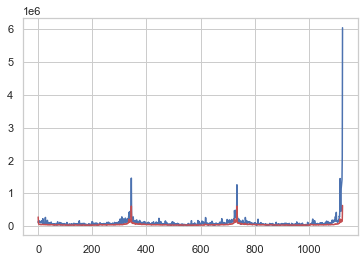

In [23]:
estVolume = predict(len(test_mem),390,alpha,beta,ds_train,s,test_mem)
plt.plot(test_mem[:,1], color = 'b')
plt.plot(estVolume[:,0], color = 'r')

In [24]:
predictionReport(test_mem[:,1],estVolume[:,0],'MEM')

Results from MEM model
MAE: 55930.62480104168
RMAE: 236.4965640364394
MSE: 40700054822.039
RMSE: 201742.54588965364
CD: 0.541814946619217
